In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [1]:
import matplotlib.pyplot as plt
from skimage import color
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import os
import numpy as np
from PIL import Image

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

#PCA for feature reduction - Note: I tried it because it made the model fit faster
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
path = 'C:/dataset2/'

In [8]:
classes = ["Bar", "Casino", "Restaurant", "Library", "Hospital"]

def load_images(data_path, classes):
    data = []
    labels = []
    for class_n in classes:
        path = os.path.join(data_path, class_n)
        l = classes.index(class_n)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
#                 img = plt.imread(img_path)  #This is for using skimage
                img = Image.open(img_path)
                if img.mode != 'RGB':
                    print(img_path)
                    print("NOT RGB")
                    continue
                img = img.resize((256,256))
                img = np.array(img)
                data.append(img)
                labels.append(l)
            except Exception as e:
                print(f"Error : {e}")
    X = np.array(data) / 255.0
    y = np.array(labels)
    return X, y

X, y = load_images(path, classes)

C:/dataset2/Bar\bar_0527.jpg
NOT RGB
C:/dataset2/Restaurant\213596.jpg
NOT RGB
C:/dataset2/Restaurant\interieur_014_png.jpg
NOT RGB


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.17, random_state=42)

In [10]:
# Flattening
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)


PCA
scaler = StandardScaler()
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(scaler.fit_transform(X_train_flat))
X_test_pca = pca.transform(scaler.transform(X_test_flat))

In [11]:
#parameter tuning - Pruning
best_accuracy = 0
best_params = {}
for max_depth in [3, 5, 7, 10, None]:
    for min_samples_split in [2, 5, 10, 20]:
        for ccp_alpha in [0.0, 0.01, 0.1, 1.0]: # Added ccp_alpha for pruning
            dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, ccp_alpha=ccp_alpha, random_state=42)
            dt.fit(X_train_pca, y_train)
            y_pred = dt.predict(X_test_pca)
            accuracy = accuracy_score(y_test, y_pred)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'max_depth': max_depth, 'min_samples_split': min_samples_split, 'ccp_alpha': ccp_alpha}

print(best_params)

dt = DecisionTreeClassifier(**best_params)
dt.fit(X_train_pca, y_train)
y_pred = dt.predict(X_test_pca)

{'max_depth': 7, 'min_samples_split': 20, 'ccp_alpha': 0.0}


In [14]:
# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=classes)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.39226519337016574
Classification Report:
              precision    recall  f1-score   support

         Bar       0.41      0.23      0.30       126
      Casino       0.42      0.60      0.49       100
  Restaurant       0.35      0.27      0.30       104
     Library       0.31      0.37      0.33        90
    Hospital       0.44      0.51      0.48       123

    accuracy                           0.39       543
   macro avg       0.39      0.40      0.38       543
weighted avg       0.39      0.39      0.38       543



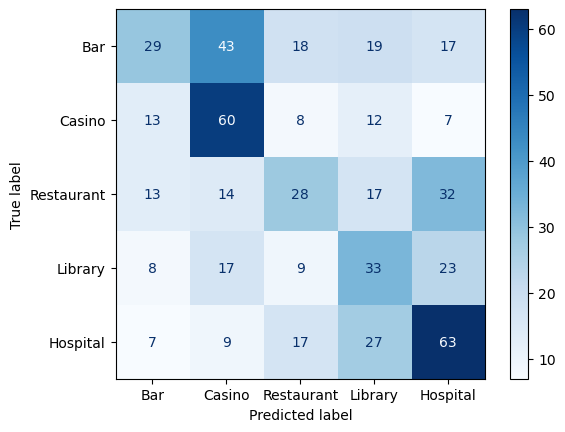

In [15]:
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes).plot(cmap=plt.cm.Blues)
plt.show()